<a href="https://colab.research.google.com/github/akatukam/K-Means-for-Vector-Quantization/blob/main/kMeansForImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using K-means Clustering for Vector Quantization**


## Overview

We illustrate this using an important application of clustering to vector quantization.  We will experiment with this in the context of images.  An image consists of pixels.  Each pixel has a red, green and blue value, which are typically represented with 8 bit unsigned integers.  This means every color has a value between 0 and 255.  If we represent these values explicitly, we need 24 bits for every pixel in the image.  If our image has N pixels, we need 24N bits.

But suppose our image only contained 256 distinct colors.  In that case, we could represent the image with much less space.  We would just need a table of 256 colors.  Then, for every pixel we could describe its color with an index into this table.  Representing such a table requires 256x24 bits, while representing the indices requires 8N bits.  Since N is typically very large (megapixel cameras are ubiquitous), we would reduce the size of our image by about a factor of 3.

But real images don't have 256 different colors, they may have millions of different colors.  But many of these colors are pretty similar, so we can often approximate an image with a small number of colors.  We want to do this with as little distortion of the true colors as possible.  K-means is perfect for this.  The cluster centers will be the colors we put in the table.  The assignment of pixels to cluster centers will tell us what color to use in the approximate image for each pixel.  And the objective function of K-means is a way of saying we want to find the colors for the table and a way of assigning pixels to these colors that minimizes the distortion of the image.

## Getting started with images


We begin by importing some standard libs.  cv2 is OpenCV, a standard library used for computer vision.

In [ ]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

Click on the links below and download the images we will be working with:
- [fruits.jpg](https://drive.google.com/file/d/1ta_ilXMawZu79z5878v84BbWGJunLWx5/view?usp=sharing)
- [fruits_small.jpg](https://drive.google.com/file/d/1Ft0ixiGWBdjuHKJ2946cR6Of87W7OGYa/view?usp=sharing)

In [ ]:
os.system('rm -fr *.jpg *.JPEG')

from google.colab import files
uploaded = files.upload()  # (you can select more than one file)

Saving fruits.jpg to fruits.jpg
Saving fruits_small.jpg to fruits_small.jpg


In [ ]:
imgsmall = cv2.imread('fruits_small.jpg')
img = cv2.imread('fruits.jpg')

In the following function, we transform the input image by adjusting the relative intensities bewteen 3 color channels. We multiply each color channel by a pre-determined weight, respectively.

In [ ]:
def weight_img(img):
    weights = np.array([1.0, 0.9, 1.2])
    weighted_img = img.astype(np.float32) * weights
    weighted_img = np.clip(weighted_img, 0, 255).astype(np.uint8)
    return weighted_img

# weighting images
img = weight_img(img)
imgsmall = weight_img(imgsmall)

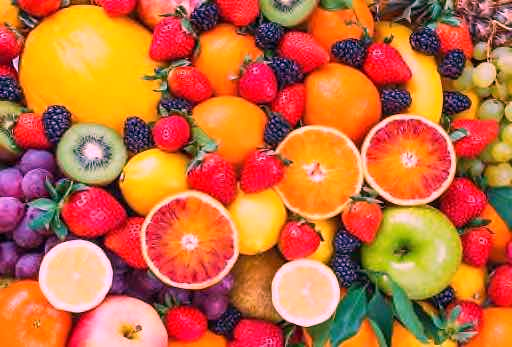

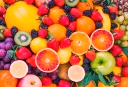

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2_imshow(imgsmall)

Each image is a 3D array.  For every (x,y) position there is a pixel, and every pixel contains three values.  These are RGB values (red, green, blue), which say how much of each color is in a pixel.

In [ ]:
x,y,z = imgsmall.shape

In [ ]:
[x,y,z]

[87, 128, 3]

See, the small image has 87 rows and 128 columns, and 3 values for each pixel.  We can access a pixel value just by indexing into it.  For example:

In [ ]:
[img[0,0,0], img[0,0,1], img[0,0,2]]

[49, 195, 255]

The expexcted output is `[49.0, 195.3, 255.0]`.

The pixel in the upper left corner is kind of orange. It's bright and warm, but it has a fair amount of R (red) and G (green), and less B (blue).

We'll begin by writing code to compute the distance from each pixel to a cluster center.


In [ ]:
def cluster_points_distance_squared(cl, img):
    cl = np.array(cl)
    cl = cl.reshape((1, 1, 3))
    distance_squared = np.sum((img - cl) ** 2, axis=2)
    return distance_squared

Just to test this, here's the output of our code on a simple problem:

In [ ]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [1,0,0]
testim[0,1,0:3] = [0,1,0]
testim[1,0,0:3] = [0,0,1]
testim[1,1,0:3] = [1,1,1]
cl = np.array([1,0,1])
cluster_points_distance_squared(cl, testim)


array([[1., 3.],
       [1., 1.]])

The output looks like:  
array([[1., 3.],
       [1., 1.]])

Now, we implement a function to decide what cluster each pixel belongs to.  You'll compute the distance from each cluster center to each pixel, and assign each pixel to the nearest cluster.  One corner case that can arise is when a pixel is equidistant to two or more cluster centers.  This can be handled in a variety of ways.  Normally, it's not too important how you deal with this.  But to make it easier for us to test your code, we will require that such a pixel be assigned to the cluster that comes first in the list, cls, which is input to the function.

In [ ]:
def cluster_members(cls, img):
    distances = np.zeros((img.shape[0], img.shape[1], len(cls)))
    for i, cl in enumerate(cls):
        distances[:, :, i] = cluster_points_distance_squared(cl, img)
    asgn = np.argmin(distances, axis=2)
    return asgn

Just to check this, we run on a simple test case.  

In [ ]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [1,1,0]
testim[0,1,0:3] = [0,1,0]
testim[1,0,0:3] = [0,1,1]
testim[1,1,0:3] = [0,0,1]
cl0 = np.array([.3, .8, 0])
cl1 = np.array([0, .1, .8])
cls = [cl0, cl1]
asgn = cluster_members(cls, testim)
asgn


array([[0, 0],
       [1, 1]])

The result of running this code is:

array([[0, 0],
       [1, 1]])

Next, we write a function that will update the centers of the clusters, based on cluster assignments that have been computed. Each cluster center should be updated to be the average of the pixels assigned to that center.

Note that it is possible that a cluster will contain no pixels.  That is ok, but must be handled without your code blowing up.  One might deal with this issue in a few different ways.  For simplicity, in your code, just assign the cluster a center of [-255,-255,-255].  This will result in the cluster being out of action, and not having any pixels assigned to it in the future.  

In [ ]:
def update_centers(asgn, img, k):
    new_centers = []
    for i in range(k):
        mask = (asgn == i)
        if not np.any(mask):
            new_centers.append([-255, -255, -255])
            continue
        cluster_pixels = img[mask]
        mean_color = cluster_pixels.mean(axis=0)
        new_centers.append(mean_color.tolist())
    return new_centers

Again, we'll try this on a simple example, using the results from the last example:

In [ ]:
cls = update_centers(asgn, testim, 2)
cls



[[0.5, 1.0, 0.0], [0.0, 0.5, 1.0]]

The answer that our code produces is:

[array([0.5, 1. , 0. ]), array([0. , 0.5, 1. ])]

Now we will put these functions together to perform k-means clustering.  We will define a function that takes as input the initial values of the clusters. We provide a simple initialization method.  This makes it easier to test your code.

In [ ]:
def initialized_k_means(cls, img, n):
    for _ in range(n):
        asgn = cluster_members(cls, img)
        cls = update_centers(asgn, img, len(cls))
    return cls, asgn

Ok, a simple example:

In [ ]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [0,0,0]
testim[0,1,0:3] = [2,0,0]
testim[1,0,0:3] = [6,0,0]
testim[1,1,0:3] = [8,0,0]
cl0 = np.array([1,0,0])
cl1 = np.array([8, 6, 0])
cls = [cl0, cl1]
cls1, asgn1 = initialized_k_means(cls, testim, 1)
print(cls1)
print(asgn1)
cls2, asgn2 = initialized_k_means(cls, testim, 2)
print(cls2)
print(asgn2)

[[2.6666666666666665, 0.0, 0.0], [8.0, 0.0, 0.0]]
[[0 0]
 [0 1]]
[[1.0, 0.0, 0.0], [7.0, 0.0, 0.0]]
[[0 0]
 [1 1]]


The result of our code is:

[array([2.66666667, 0.        , 0.        ]), array([8., 0., 0.])]
[[0 0]
 [0 1]]
[array([1., 0., 0.]), array([7., 0., 0.])]
[[0 0]
 [1 1]]

Ok, we are now ready to quantize an image.  We will provide a baseline function to initialize the cluster centers, and a function to measure how close the quantized image is from the original image, to allow evaluation. Make sure you convert all the cluster centers into integers before creating make an image.

In [ ]:
def simple_init(k):
  # Function will return a list of k classes.
  # Note that rgb values are between 0 and 255.
  np.random.seed(42)
  cls = [];
  for i in range(k):
    cls += [np.random.randint(0,256,3)]
  return cls

def compare_images(img1, img2):
  return np.sqrt(np.sum((img1-img2)**2))

In [ ]:
def quantize_image(img, k, n):
    cls = simple_init(k)
    final_cls, asgn = initialized_k_means(cls, img, n)
    final_cls_int = np.array(final_cls).astype(int)
    new_img = np.zeros_like(img)
    for i in range(len(final_cls_int)):
        new_img[asgn == i] = final_cls_int[i]
    return new_img, final_cls_int

Now we can run this code on a real image.  We can see that when we use 128 colors, we get something that looks pretty similar to the original image.  With 8 colors, there are noticeable artifacts, but we have a comprehensible image.  This might be useful for very compact thumbnails.

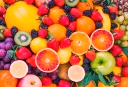

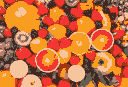

1755.9111594838732


In [ ]:
qimg8, cls8 = quantize_image(imgsmall, 8, 10)
cv2_imshow(imgsmall)
cv2_imshow(qimg8)
print(compare_images(imgsmall, qimg8))

We can look at this on the full-sized image too, though this is going to take a lot longer to run (took me around 30 minutes).

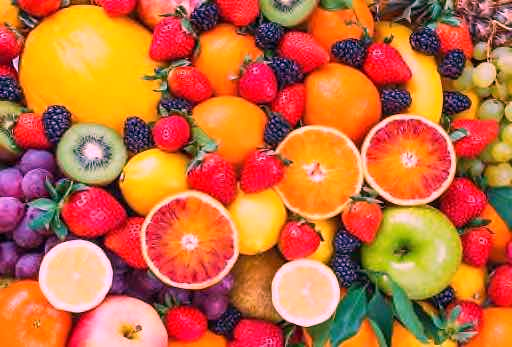

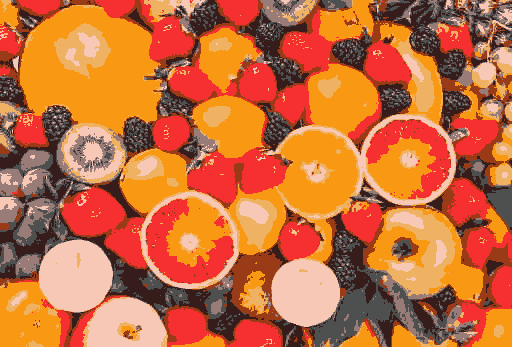

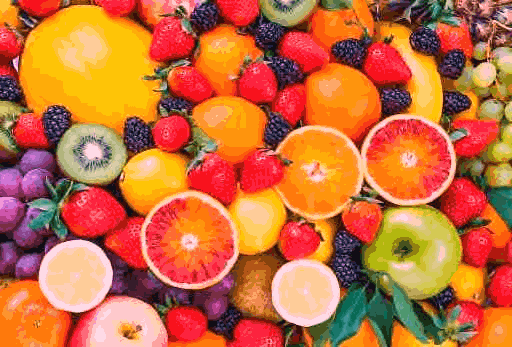

6838.351921333093
5690.543998599783


In [ ]:
qimg8, cls8 = quantize_image(img, 8, 10)
qimg128, cls128 = quantize_image(img, 128, 10)
cv2_imshow(img)
cv2_imshow(qimg8)
cv2_imshow(qimg128)
print(compare_images(img, qimg8))
print(compare_images(img, qimg128))

## Problem 6 (15 Points)

Finally, the last problem is to find a way to improve on these results.  That is, we need to find a way to improve k-means so that it produces a better image, using the same number of clusters.

In [ ]:
def spread_init(img, k):
    np.random.seed(42)
    pixels = img.reshape(-1, img.shape[2])
    indices = np.random.choice(pixels.shape[0], k, replace=False)
    cls = pixels[indices]
    return cls

def better_quantize_image(img, k, n):
    cls = spread_init(img, k)
    cls = cls.tolist() if not isinstance(cls, list) else cls
    final_cls, asgn = initialized_k_means(cls, img, n)
    final_cls_int = np.array(final_cls).astype(int)
    new_img = np.zeros_like(img)
    for i, center in enumerate(final_cls_int):
        mask = asgn == i
        new_img[mask] = center
    return new_img, final_cls_int

Here is an example showing our codes performance

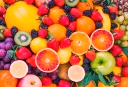

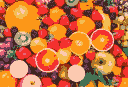

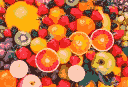

1711.9891938911296
1632.8420009296674


In [ ]:
qimgsmall1, cls1 = quantize_image(imgsmall, 16, 10)
qimgsmall2, cls2 = better_quantize_image(imgsmall, 16, 10)
cv2_imshow(imgsmall)
cv2_imshow(qimgsmall1)
cv2_imshow(qimgsmall2)
print(compare_images(imgsmall, qimgsmall1))
print(compare_images(imgsmall, qimgsmall2))